Experimental Setup and Results- Vector Embedding sentencetransformer

In [ ]:
from sklearn.cluster import KMeans
from graph_filters import graph_filtering
from scipy.io import loadmat
from sklearn.metrics.cluster import adjusted_mutual_info_score as ami
import numpy as np
from sklearn.metrics import adjusted_rand_score as ari
from time import time
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib as plt
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
from sklearn.cluster import HDBSCAN
import bcubed
from sklearn.cluster import MeanShift,estimate_bandwidth
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
import hdbscan
from sklearn.metrics import make_scorer

In [3]:

#  /Users/prachiteechouhan/Documents/CPSC DSP /Topic-based clustering/SentenceTransformer-Smoothing/data/embeddings
metrics_all={}

def smoothing_kmeans():
    runs = 5
    degree = 3
    metrics_sm_kmeans={}
    for method in [ 
        'sgc',
        's2gc',
        'dgc',
        'appnp'
    ]:
        print(f'{method}:')
        dataset = 'cluster_data'#abstract' #:name your dataset here

        data = loadmat(f'data/embeddings/{dataset}-sentencetransformer-embedding.mat')
        features = data['x']
        labels = data['y'].reshape(-1)

        n_clusters = len(np.unique(labels))

        t0 = time()
        if method:
            features = graph_filtering(features, method=method)
        pre_time = time() - t0
        
        metrics_sm = {'silhouettescore':[],'db_index':[],'ami': [], 'ari': [],'precision':[],'recall':[],'fscore':[]}

        for run in range(runs):
            t0 = time()
            Z = KMeans(n_clusters,random_state=0, n_init=10).fit_predict(features)
            metrics_sm['silhouettescore'].append(silhouette_score(features, Z, metric='euclidean'))
            metrics_sm['db_index'].append(davies_bouldin_score(features, Z))
            #metrics_sm['ch_index'].append(calinski_harabasz_score(features, Z))
                
            metrics_sm['ami'].append(ami(labels, Z))
            metrics_sm['ari'].append(ari(labels, Z))
            data = pd.read_csv(f'data/text/{dataset}.csv')
            text = data['text']
            cdict={}
            for i in range(len(text)):  
                cdict[text[i]]=set([labels[i]])

            ldict={}
            for i in range(len(text)):  
                ldict[text[i]]=set([Z[i]])
        
            precision = bcubed.precision(cdict, ldict)
            recall = bcubed.recall(cdict, ldict)
            fscore = bcubed.fscore(precision, recall)
                
                
            metrics_sm['precision'].append(precision)
            metrics_sm['recall'].append(recall)
            metrics_sm['fscore'].append(fscore)
            #print("Bcubed metric for:")
            #print(f'Precision: {precision}')
            #print(f'Recall: {recall}')
            #print(f'Fscore: {fscore}') 

            #storing resu;lt for further analysis
            data={'text':text,'ActualLabel':labels,'PredictedLabel':Z}
            pred_df=pd.DataFrame(data)
            #print(pred_df)
            pred_df.to_csv(f"data/Smoothing-km/{method}/sm-{method}.csv")
        

                #metrics_sm['time'].append(pre_time + time() - t0)
        results = {
            'mean': {k: (np.mean(v)).round(4) for k, v in metrics_sm.items()},
            'std': {k: (np.std(v)).round(4) for k, v in metrics_sm.items()}
        }
            
        means = results['mean']
        stds = results['std']
        means_std=[means,stds]
            #print(f'\tmeans: ', means['silhouettescore'],means['db_index'],means['ch_index'],means['ami'], means['ari'], sep='&')
            #print(f'\tstds: ', stds['silhouettescore'],stds['db_index'],stds['ch_index'],stds['ami'], stds['ari'], sep='&')
        metrics_sm_kmeans[method]=means
    #metrics_all['smoothing_kmeans']=metrics_sm_kmeans
    return metrics_sm_kmeans

In [4]:
eval_k=smoothing_kmeans()

sgc:
s2gc:
dgc:
appnp:


In [6]:
def smoothing_hdbscan():
    runs = 1
    degree = 2
    metrics_sm_kmeans={}
    for method in [
        'sgc',
        's2gc',
        'dgc',
        'appnp'
    ]:
        print(f'{method}:')
        dataset ='cluster_data' # put name of your dataset withour csv ext
           

        data = loadmat(f'data/embeddings/{dataset}-sentencetransformer-embedding.mat')
        features = data['x']
        labels = data['y'].reshape(-1)

        n_clusters = len(np.unique(labels))

        t0 = time()
        if method:
            features = graph_filtering(features, method=method)
        pre_time = time() - t0
        
        metrics_sm = {'silhouettescore':[],'db_index':[],'ami': [], 'ari': [],'precision':[],'recall':[],'fscore':[]}

        for run in range(runs):
            t0 = time()
            hdb = HDBSCAN()
            param_dist = {
              'min_cluster_size':[2,3,5],  
              'cluster_selection_method' : ['eom','leaf'],
              'metric' : ['euclidean','manhattan'] 
              }
            n_iter_search=3
            validity_scorer = make_scorer(hdbscan.validity.validity_index,greater_is_better=True)

            random_search = RandomizedSearchCV(hdb
                                   ,param_distributions=param_dist
                                   ,n_iter=n_iter_search
                                   ,scoring=validity_scorer 
                                   ,random_state=0)

            random_search.fit(features)
            print(f"Best Parameters for {method}: {random_search.best_params_}")




            hdb = HDBSCAN(min_cluster_size= 2, metric= 'euclidean', cluster_selection_method= 'leaf')
       
            y_pred_hdb= hdb.fit_predict(features)
            if np.isnan(y_pred_hdb).any():
                raise ValueError("Predictions contain NaN values")
        
            print(np.unique(y_pred_hdb))
        
            metrics_sm['silhouettescore'].append(silhouette_score(features, y_pred_hdb, metric='euclidean'))
            metrics_sm['db_index'].append(davies_bouldin_score(features, y_pred_hdb))
            #metrics_sm['ch_index'].append(calinski_harabasz_score(features, y_pred_hdb))
                
            metrics_sm['ami'].append(ami(labels, y_pred_hdb))
            metrics_sm['ari'].append(ari(labels, y_pred_hdb))

                
            data = pd.read_csv(f'data/text/{dataset}.csv')
            text = data['text']
            cdict={}
            for i in range(len(text)):  
                cdict[text[i]]=set([labels[i]])

            ldict={}
            for i in range(len(text)):  
                ldict[text[i]]=set([y_pred_hdb[i]])
        
            precision = bcubed.precision(cdict, ldict)
            recall = bcubed.recall(cdict, ldict)
            fscore = bcubed.fscore(precision, recall)
            print("Bcubed metric for:")
            print(f'Precision: {precision}')
            print(f'Recall: {recall}')
            print(f'Fscore: {fscore}') 
            metrics_sm['precision'].append(precision)
            metrics_sm['recall'].append(recall)
            metrics_sm['fscore'].append(fscore)

                #metrics_sm['time'].append(pre_time + time() - t0)

                #storing resu;lt for further analysis
            data={'text':text,'ActualLabel':labels,'PredictedLabel':y_pred_hdb}
            pred_df=pd.DataFrame(data)
                #print(pred_df)
            pred_df.to_csv(f"data/Smoothing-hdbscan/{method}/smh-{method}.csv")
        
        results = {
            'mean': {k: (np.mean(v)).round(4) for k, v in metrics_sm.items()},
            'std': {k: (np.std(v)).round(4) for k, v in metrics_sm.items()}
        }
        means = results['mean']
        stds = results['std']
        means_std=[means,stds]
            #print(f'\tmeans: ', means['silhouettescore'],means['db_index'],means['ch_index'],means['ami'], means['ari'], sep='&')
            #print(f'\tstds: ', stds['silhouettescore'],stds['db_index'],stds['ch_index'],stds['ami'], stds['ari'], sep='&')
        metrics_sm_kmeans[method]=means
    #metrics_all['smoothing_kmeans']=metrics_sm_kmeans
    return metrics_sm_kmeans

In [7]:
eval_h=smoothing_hdbscan()

sgc:
Best Parameters for sgc: {'min_cluster_size': 2, 'metric': 'euclidean', 'cluster_selection_method': 'leaf'}
[-1  0  1  2  3  4]
Bcubed metric for:
Precision: 0.5291375291375292
Recall: 0.9393939393939393
Fscore: 0.676960076960077
s2gc:
Best Parameters for s2gc: {'min_cluster_size': 2, 'metric': 'euclidean', 'cluster_selection_method': 'leaf'}
[-1  0  1  2  3  4]
Bcubed metric for:
Precision: 0.5291375291375291
Recall: 0.9204545454545454
Fscore: 0.6719780721790771
dgc:
Best Parameters for dgc: {'min_cluster_size': 2, 'metric': 'euclidean', 'cluster_selection_method': 'leaf'}
[-1  0  1  2  3  4  5  6  7]
Bcubed metric for:
Precision: 0.34149184149184153
Recall: 0.881818181818182
Fscore: 0.492326080931264
appnp:
Best Parameters for appnp: {'min_cluster_size': 2, 'metric': 'euclidean', 'cluster_selection_method': 'leaf'}
[-1  0  1  2  3  4]
Bcubed metric for:
Precision: 0.5291375291375291
Recall: 0.9204545454545454
Fscore: 0.6719780721790771


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() mis

Smoothing-MeanShift

In [8]:
metrics_all={}

def smoothing_meanshift():
    runs = 1
    degree = 3
    metrics_sm_kmeans={}
    hyp_para={}
    for method in [
        'sgc',
        's2gc',
        'dgc',
        'appnp'
    ]:
        print(f'{method}:')
        dataset = 'cluster_data'

        data = loadmat(f'data/embeddings/{dataset}-sentencetransformer-embedding.mat')
        features1 = data['x']
        labels = data['y'].reshape(-1)

        n_clusters = len(np.unique(labels))

        t0 = time()
        if method:
            features = graph_filtering(features1, method=method)
        pre_time = time() - t0
        
        metrics_sm = {'silhouettescore':[],'db_index':[],'ami': [], 'ari': [],'precision':[],'recall':[],'fscore':[]}

        for run in range(runs):
            t0 = time()
            y_pred_hyp_para=[]

            for q in np.arange(0.1,0.5,0.05):
                ibandwidth=estimate_bandwidth(features,quantile=q)
                sclustering= MeanShift(bandwidth=ibandwidth,max_iter=500)
       
                y_pred= sclustering.fit_predict(features)
                y_pred_hyp_para.append(ari(labels, y_pred))
               

            ibandwidth = estimate_bandwidth(features, quantile=0.35,random_state=42)
            msclustering= MeanShift(bandwidth=ibandwidth,max_iter=500)
            Z= msclustering.fit_predict(features)
            print(np.unique(Z))
            metrics_sm['silhouettescore'].append(0)#silhouette_score(features, Z, metric='euclidean'))
            metrics_sm['db_index'].append(0)#davies_bouldin_score(features, Z))
            #metrics_sm['ch_index'].append(calinski_harabasz_score(features, Z))
                
            metrics_sm['ami'].append(ami(labels, Z))
            metrics_sm['ari'].append(ari(labels, Z))
            data = pd.read_csv(f'data/text/{dataset}.csv')
            text = data['text']
            cdict={}
            for i in range(len(text)):  
                cdict[text[i]]=set([labels[i]])

            ldict={}
            for i in range(len(text)):  
                ldict[text[i]]=set([Z[i]])
        
            precision = bcubed.precision(cdict, ldict)
            recall = bcubed.recall(cdict, ldict)
            fscore = bcubed.fscore(precision, recall)
                
                
            metrics_sm['precision'].append(precision)
            metrics_sm['recall'].append(recall)
            metrics_sm['fscore'].append(fscore)
            print("Bcubed metric for:")
            print(f'Precision: {precision}')
            print(f'Recall: {recall}')
            print(f'Fscore: {fscore}') 

            #storing resu;lt for further analysis
            data={'text':text,'ActualLabel':labels,'PredictedLabel':Z}
            pred_df=pd.DataFrame(data)
            #print(pred_df)
            pred_df.to_csv(f"data/Smoothing-meanshift/{method}/smms-{method}.csv")
        

                #metrics_sm['time'].append(pre_time + time() - t0)
        results = {
            'mean': {k: (np.mean(v)).round(4) for k, v in metrics_sm.items()},
            'std': {k: (np.std(v)).round(4) for k, v in metrics_sm.items()}
        }
            
        means = results['mean']
        stds = results['std']
        means_std=[means,stds]
            #print(f'\tmeans: ', means['silhouettescore'],means['db_index'],means['ch_index'],means['ami'], means['ari'], sep='&')
            #print(f'\tstds: ', stds['silhouettescore'],stds['db_index'],stds['ch_index'],stds['ami'], stds['ari'], sep='&')
        metrics_sm_kmeans[method]=means
        #hyp_para
        hyp_para[method]=y_pred_hyp_para

    #metrics_all['smoothing_kmeans']=metrics_sm_kmeans
    print(hyp_para)
    x_values = np.arange(0.1,0.5,0.05) #* len(y_preds)
    for key, values in hyp_para.items():
        plt.plot(x_values[:len(values)], values, label=key)
    #plt.plot(x_values, y_pred, label=f'Quantile: {x_values}')
    plt.xlabel('Quantile')
    plt.ylabel('Adjusted Rand Index')
    plt.title('Sm-MeanShift-SentenceTransformer Clustering Predictions for Different Quantile Values and differnt polynomial filters')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()   
    return metrics_sm_kmeans

sgc:
[0 1 2]
Bcubed metric for:
Precision: 1.0
Recall: 0.922077922077922
Fscore: 0.9594594594594594
s2gc:
[0 1]
Bcubed metric for:
Precision: 1.0
Recall: 0.5590909090909092
Fscore: 0.7172011661807581
dgc:
[0 1 2 3]
Bcubed metric for:
Precision: 0.7703962703962705
Recall: 0.8863636363636364
Fscore: 0.8243212995235507
appnp:
[0 1]
Bcubed metric for:
Precision: 1.0
Recall: 0.5590909090909092
Fscore: 0.7172011661807581
{'sgc': [0.48928571428571427, 0.46664707610931533, 0.46664707610931533, 0.7765417170495768, 0.946720996386561, 0.946720996386561, 0.8858825764772943, 0.8858825764772943], 's2gc': [0.48928571428571427, 0.4553846153846154, 0.4553846153846154, 0.25127811006783174, 0.25127811006783174, 0.25127811006783174, 0.25127811006783174, 0.25127811006783174], 'dgc': [0.2775844602034973, 0.5442256832206877, 0.6989247311827957, 0.5563256784968684, 0.6183079973562459, 0.702055622732769, 0.702055622732769, 0.622049084534476], 'appnp': [0.48928571428571427, 0.4553846153846154, 0.455384615384615

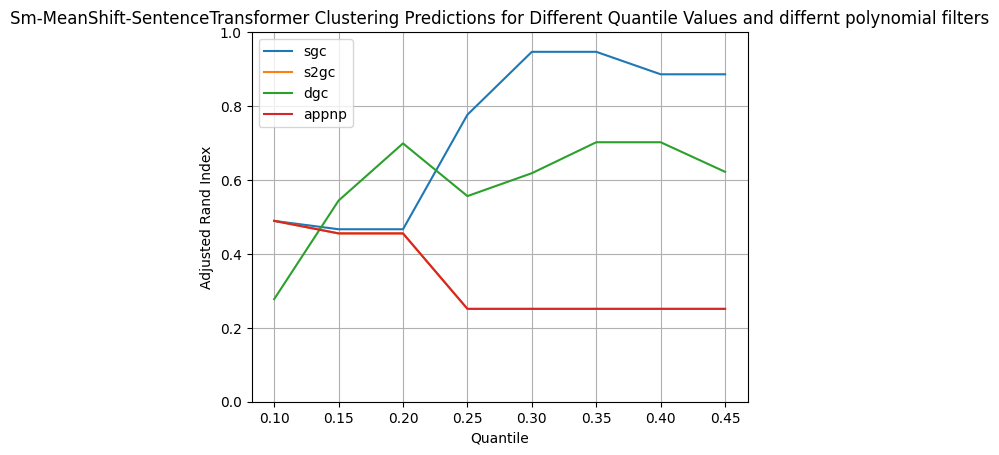

In [10]:
eval_sm_ms= smoothing_meanshift()

In [11]:
eval_sm_ms

{'sgc': {'silhouettescore': 0.0,
  'db_index': 0.0,
  'ami': 0.9193,
  'ari': 0.9467,
  'precision': 1.0,
  'recall': 0.9221,
  'fscore': 0.9595},
 's2gc': {'silhouettescore': 0.0,
  'db_index': 0.0,
  'ami': 0.4004,
  'ari': 0.2513,
  'precision': 1.0,
  'recall': 0.5591,
  'fscore': 0.7172},
 'dgc': {'silhouettescore': 0.0,
  'db_index': 0.0,
  'ami': 0.6848,
  'ari': 0.7021,
  'precision': 0.7704,
  'recall': 0.8864,
  'fscore': 0.8243},
 'appnp': {'silhouettescore': 0.0,
  'db_index': 0.0,
  'ami': 0.4004,
  'ari': 0.2513,
  'precision': 1.0,
  'recall': 0.5591,
  'fscore': 0.7172}}

K-means

In [14]:
def kmeans_clustering():
    dataset = 'cluster_data' #'abstract' # assign name of your dataset here
    data = loadmat(f'data/embeddings/{dataset}-sentencetransformer-embedding.mat')
    features = data['x']
    labels = data['y'].reshape(-1)
    metrics={}   
    n_clusters = len(np.unique(labels))
    print(n_clusters)
    hyp_para=[]
    for i in range(1,len(labels)+1):
        clusterer = KMeans(n_clusters= i, random_state=7)
        y_pred_kmeans = clusterer.fit_predict(features)
        hyp_para.append(ari(labels, y_pred_kmeans))

    plt.figure(figsize=(10, 6))

    
    x_values = np.arange(1,len(labels)+1,1) #* len(y_preds)
    plt.plot(x_values, hyp_para, label=f'K: {x_values}')
    plt.xlabel('K')
    plt.ylabel('Adjusted Rand Index')
    plt.title('K-means-SentenceTransformer Clustering Predictions for Different K Values')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.xticks(np.arange(1, len(labels), 1)) 
    plt.show()   

    
    
    clusterer = KMeans(n_clusters= 4, random_state=7)
    y_pred_kmeans = clusterer.fit_predict(features)
    # centers = clusterer.cluster_centers_
    silhouettescore = silhouette_score (features, y_pred_kmeans, metric='euclidean')
        
    ari1 = ari(labels, y_pred_kmeans)
    mi = ami(labels, y_pred_kmeans) 
    db_index = davies_bouldin_score(features, y_pred_kmeans)
    ch_index = calinski_harabasz_score(features, y_pred_kmeans) 
        #y_true = np.array(labels)
        #y_pred = np.array(y_pred_kmeans)
        #prf= precision_recall_fscore_support(y_true, y_pred, average='macro')
        #print(prf)
    data = pd.read_csv(f'data/text/{dataset}.csv')
    text = data['text']
    t_labels=data['label']
    cdict={}
    for i in range(len(text)):  
        cdict[text[i]]=set([labels[i]])

    ldict={}
    for i in range(len(text)):  
        ldict[text[i]]=set([y_pred_kmeans[i]])
        
    precision = bcubed.precision(cdict, ldict)
    recall = bcubed.recall(cdict, ldict)
    fscore = bcubed.fscore(precision, recall)
    print("Bcubed metric for:")
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'Fscore: {fscore}') 
        
    data={'text':text,'ActualLabel':labels,'PredictedLabel':y_pred_kmeans}
    pred_df=pd.DataFrame(data)
        #for i in range(len(text)):
         #   new_df=pd.DataFrame({text[i],labels[i],y_pred_kmeans[i]})
          #  pred_df=pd.concat([pred_df,new_df], ignore_index=True)
        #print(pred_df)
    pred_df.to_csv("data/K-means/k-means.csv")
        #  globals()[f"df_{cat}"].to_csv(f"/Users/prachiteechouhan/Documents/CPSC DSP /Topic-based clustering/SentenceTransformer-Smoothing/data/k-means/df-{cat}.csv")
       # Print the metric scores
        #print(f"K-Means for dataset: {dataset}")
        #print(f"Silhouette Score: {silhouettescore:.2f}")
        #print(f"Davies-Bouldin Index: {db_index:.2f}")
        #print(f"Calinski-Harabasz Index: {ch_index:.2f}")
        #print(f"Mutual Information (MI): {mi:.2f}")
        #print(f"Adjusted Rand Index: {ari:.2f}")
       
    metrics={'silhouettescore':silhouettescore,'db_index':db_index,'ami':mi,'ari':ari1,'precision':precision,'recall':recall,'fscore':fscore}
    return metrics

4


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

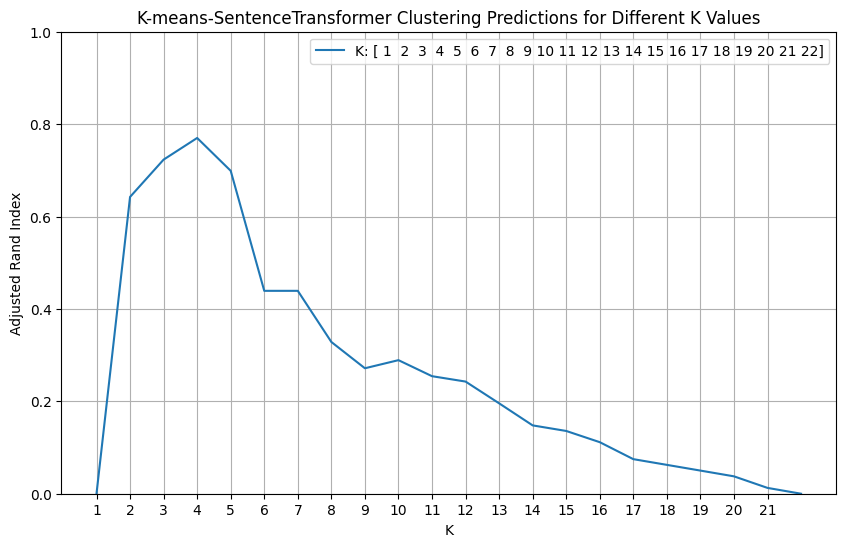

Bcubed metric for:
Precision: 0.7948717948717949
Recall: 0.8863636363636364
Fscore: 0.8381282495667244


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [15]:
evalk=kmeans_clustering()

HDBSCAN

In [17]:
def hdbscanClustering():
    dataset = 'cluster_data' 
    data = loadmat(f'data/embeddings/{dataset}-sentencetransformer-embedding.mat')
    features = data['x']
    labels = data['y'].reshape(-1)
        #print(labels)
    metrics={}
    n_clusters = len(np.unique(labels))
    hdb = HDBSCAN()
    param_dist = {
              'min_cluster_size':[2,3,5],  
              'cluster_selection_method' : ['eom','leaf'],
              'metric' : ['euclidean','manhattan'] 
             }
    n_iter_search=3
    validity_scorer = make_scorer(hdbscan.validity.validity_index,greater_is_better=True)

    random_search = RandomizedSearchCV(hdb
                                   ,param_distributions=param_dist
                                   ,n_iter=n_iter_search
                                   ,scoring=validity_scorer 
                                   ,random_state=0)

    random_search.fit(features)
    print(f"Best Parameters {random_search.best_params_}")
    hdb=HDBSCAN(min_cluster_size= 2, metric= 'euclidean', cluster_selection_method= 'leaf')
    y_pred_hdb= hdb.fit_predict(features)

    print(np.unique(y_pred_hdb))
    if np.isnan(y_pred_hdb).any():
        raise ValueError("Predictions contain NaN values")
        
        #print(np.unique(y_pred_hdb))
    silhouette_AgglomerativeClustering = silhouette_score(features, y_pred_hdb)
    db_index_AgglomerativeClustering = davies_bouldin_score(features, y_pred_hdb)
    #ch_index_AgglomerativeClustering =0 # calinski_harabasz_score(features, y_pred_hdb)
    ari_AgglomerativeClustering =ari(labels, y_pred_hdb)
    mi_AgglomerativeClustering =ami(labels, y_pred_hdb)
        
    data = pd.read_csv(f'data/text/{dataset}.csv')
    text = data['text']
    cdict={}
    for i in range(len(text)):  
        cdict[text[i]]=set([labels[i]])

    ldict={}
    for i in range(len(text)):  
        ldict[text[i]]=set([y_pred_hdb[i]])
        
    precision = bcubed.precision(cdict, ldict)
    recall = bcubed.recall(cdict, ldict)
    fscore = bcubed.fscore(precision, recall)
    print("Bcubed metric for:")
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'Fscore: {fscore}') 

        #storing resu;lt for further analysis
    data={'text':text,'ActualLabel':labels,'PredictedLabel':y_pred_hdb}
    pred_df=pd.DataFrame(data)
        #print(pred_df)
    pred_df.to_csv(f"data/HDBSCAN/Hdbscan.csv")
        
        # Print the metric scores
        #print(f"Agglomerative Clustering for dataset: {dataset}")
        #print(f"Silhouette Score: {silhouette_AgglomerativeClustering:.2f}")
        #print(f"Davies-Bouldin Index: {db_index_AgglomerativeClustering:.2f}")
        #print(f"Calinski-Harabasz Index: {ch_index_AgglomerativeClustering:.2f}")
        #print(f"Mutual Information (MI): {mi_AgglomerativeClustering:.2f}")
        #print(f"Adjusted Rand Index: {ari_AgglomerativeClustering:.2f}")
        
    metrics={'silhouettescore':silhouette_AgglomerativeClustering,'db_index':db_index_AgglomerativeClustering,'ami':mi_AgglomerativeClustering,'ari':ari_AgglomerativeClustering,'precision':precision,'recall':recall,'fscore':fscore}
    return metrics

Evaluation- HDBSCAN

In [18]:
eval_hdb= hdbscanClustering()

Best Parameters {'min_cluster_size': 2, 'metric': 'euclidean', 'cluster_selection_method': 'leaf'}
[-1  0  1  2  3  4]
Bcubed metric for:
Precision: 0.5291375291375291
Recall: 0.9204545454545454
Fscore: 0.6719780721790771


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() mis

In [19]:
eval_hdb

{'silhouettescore': 0.11129124,
 'db_index': 1.6986625564936253,
 'ami': 0.5503417546179536,
 'ari': 0.36277214276620123,
 'precision': 0.5291375291375291,
 'recall': 0.9204545454545454,
 'fscore': 0.6719780721790771}

Meam-shift Clustering

In [20]:
def meanshiftClustering():
    dataset = 'cluster_data' #abstract'
    data = loadmat(f'data/embeddings/{dataset}-sentencetransformer-embedding.mat')
    features = data['x']
    labels = data['y'].reshape(-1)
    print(len(features[0]))
    y_pred=[]
    metrics={}
    n_clusters = len(np.unique(labels))
    for q in np.arange(0.1,0.5,0.05):
        
       
        ibandwidth=estimate_bandwidth(features,quantile=q,random_state=42)
        sclustering= MeanShift(bandwidth=ibandwidth)
       
        y_pred_hdb= sclustering.fit_predict(features)
        y_pred.append(ari(labels, y_pred_hdb))
    plt.figure(figsize=(10, 6))

    
    x_values = np.arange(0.1,0.5,0.05) #* len(y_preds)
    plt.plot(x_values, y_pred, label=f'Quantile: {x_values}')
    plt.xlabel('Quantile')
    plt.ylabel('Adjusted Rand Index')
    plt.title('MeanShift-SentenceTransformer Clustering Predictions for Different Quantile Values')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()   

   
    ibandwidth=estimate_bandwidth(features,quantile=0.10,random_state=42)
    sclustering= MeanShift(bandwidth=ibandwidth)
       
    y_pred_hdb= sclustering.fit_predict(features)
    print(np.unique(y_pred_hdb))
    if np.isnan(y_pred_hdb).any():
        raise ValueError("Predictions contain NaN values")
        
        #print(np.unique(y_pred_hdb))
    silhouette_Clustering = silhouette_score(features, y_pred_hdb)
    db_index_Clustering = davies_bouldin_score(features, y_pred_hdb)
    #ch_index_AgglomerativeClustering =calinski_harabasz_score(features, y_pred_hdb)
    ari_Clustering =ari(labels, y_pred_hdb)
    mi_Clustering =ami(labels, y_pred_hdb)
        
    data = pd.read_csv(f'data/text/{dataset}.csv')
    text = data['text']
    cdict={}
    for i in range(len(text)):  
        cdict[text[i]]=set([labels[i]])

    ldict={}
    for i in range(len(text)):  
        ldict[text[i]]=set([y_pred_hdb[i]])
        
    precision = bcubed.precision(cdict, ldict)
    recall = bcubed.recall(cdict, ldict)
    fscore = bcubed.fscore(precision, recall)
    print("Bcubed metric for:")
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'Fscore: {fscore}') 

        #storing resu;lt for further analysis
    data={'text':text,'ActualLabel':labels,'PredictedLabel':y_pred_hdb}
    pred_df=pd.DataFrame(data)
        #print(pred_df)
    pred_df.to_csv(f"data/HDBSCAN/Hdbscan.csv")
        
        # Print the metric scores
        #print(f"Agglomerative Clustering for dataset: {dataset}")
        #print(f"Silhouette Score: {silhouette_AgglomerativeClustering:.2f}")
        #print(f"Davies-Bouldin Index: {db_index_AgglomerativeClustering:.2f}")
        #print(f"Calinski-Harabasz Index: {ch_index_AgglomerativeClustering:.2f}")
        #print(f"Mutual Information (MI): {mi_AgglomerativeClustering:.2f}")
        #print(f"Adjusted Rand Index: {ari_AgglomerativeClustering:.2f}")
        
    metrics={'silhouettescore':silhouette_Clustering,'db_index':db_index_Clustering,'ami':mi_Clustering,'ari':ari_Clustering,'precision':precision,'recall':recall,'fscore':fscore}
    return metrics

768


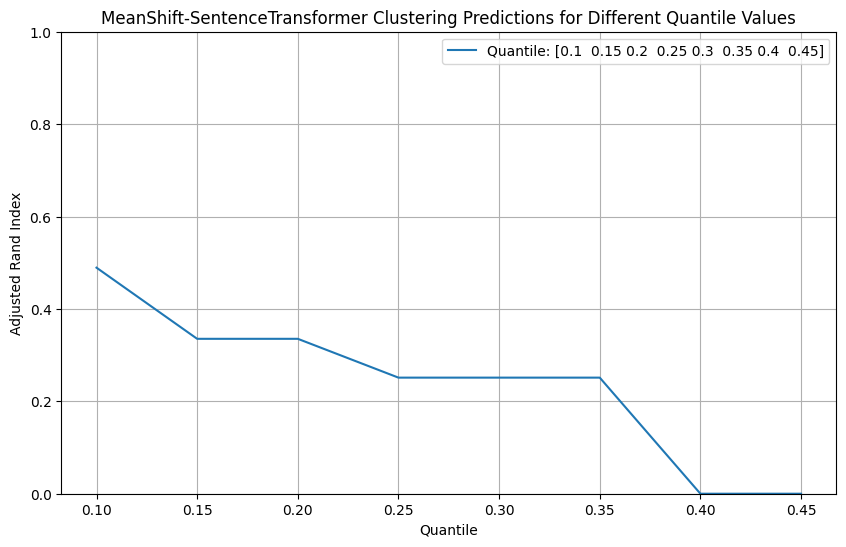

[ 0  1  2  3  4  5  6  7  8  9 10]
Bcubed metric for:
Precision: 0.5244755244755244
Recall: 1.0
Fscore: 0.6880733944954127


In [21]:
eval_sc= meanshiftClustering()

In [22]:
eval_sc

{'silhouettescore': 0.12107358,
 'db_index': 0.6408275210248482,
 'ami': 0.5186442500377475,
 'ari': 0.48928571428571427,
 'precision': 0.5244755244755244,
 'recall': 1.0,
 'fscore': 0.6880733944954127}

Evaluation Metrics Calculation

Evaluation Smoothing - Graph Filter

In [24]:
eval_sm= smoothing_kmeans()

sgc:
s2gc:
dgc:
appnp:


In [25]:
print(eval_sm)

{'sgc': {'silhouettescore': 0.3816, 'db_index': 0.8768, 'ami': 0.6283, 'ari': 0.6462, 'precision': 0.7249, 'recall': 0.8545, 'fscore': 0.7844}, 's2gc': {'silhouettescore': 0.2825, 'db_index': 1.1547, 'ami': 0.7026, 'ari': 0.77, 'precision': 0.7949, 'recall': 0.8864, 'fscore': 0.8381}, 'dgc': {'silhouettescore': 0.5269, 'db_index': 0.5952, 'ami': 0.6848, 'ari': 0.7021, 'precision': 0.7704, 'recall': 0.8864, 'fscore': 0.8243}, 'appnp': {'silhouettescore': 0.2621, 'db_index': 1.2284, 'ami': 0.7026, 'ari': 0.77, 'precision': 0.7949, 'recall': 0.8864, 'fscore': 0.8381}}


In [47]:

eval_s={}
for group, list_of_dicts in eval_sm.items():
    #print(f'{group}: list_of_dicts[0].values()')
    eval_s[f'sm-{group}-kmeans-st']=list(list_of_dicts.values())

In [48]:
new_eval_s_df = pd.DataFrame(eval_s).transpose()
new_eval_s_df.columns=['Silhouette score', 'Davies-Bouldin Index','Adjusted Mutual Information','Adjusted Rand Index','Bcubed-Precision','Bcubed-Recall','Bcubed-Fscore']
new_eval_s_df1=new_eval_s_df[['Adjusted Mutual Information','Adjusted Rand Index','Bcubed-Precision','Bcubed-Recall','Bcubed-Fscore']]
new_eval_s_df1

,Adjusted Mutual Information,Adjusted Rand Index,Bcubed-Precision,Bcubed-Recall,Bcubed-Fscore
sm-sgc-kmeans-st,0.6184,0.6625,0.7809,0.8043,0.7925
sm-s2gc-kmeans-st,0.7848,0.7336,0.8528,0.8841,0.8682
sm-dgc-kmeans-st,0.5123,0.4536,0.6739,0.7391,0.7050
sm-appnp-kmeans-st,0.6598,0.6325,0.7876,0.8159,0.8015


Evaluation Smoothing - Graph Filter- HDBSCAN

In [59]:
eval_shdscan= smoothing_hdbscan()

sgc:
Best Parameters for sgc: {'min_cluster_size': 2, 'metric': 'euclidean', 'cluster_selection_method': 'leaf'}
[-1  0  1  2  3  4]
Bcubed metric for:
Precision: 0.5501672240802676
Recall: 0.8173913043478261
Fscore: 0.6576711644177912
s2gc:
Best Parameters for s2gc: {'min_cluster_size': 2, 'metric': 'euclidean', 'cluster_selection_method': 'leaf'}
[-1  0  1  2  3  4  5]
Bcubed metric for:
Precision: 0.5250836120401337
Recall: 0.8695652173913043
Fscore: 0.6547805234073609
dgc:
Best Parameters for dgc: {'min_cluster_size': 2, 'metric': 'euclidean', 'cluster_selection_method': 'leaf'}
[-1  0  1  2  3  4  5  6  7]
Bcubed metric for:
Precision: 0.3411371237458194
Recall: 0.8043478260869565
Fscore: 0.47908600444303395
appnp:
Best Parameters for appnp: {'min_cluster_size': 2, 'metric': 'euclidean', 'cluster_selection_method': 'leaf'}
[-1  0  1  2  3  4  5]
Bcubed metric for:
Precision: 0.5250836120401337
Recall: 0.8695652173913043
Fscore: 0.6547805234073609


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:988: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 975, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:988: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 975, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^

In [60]:
eval_shdscan
eval_s={}
for group, list_of_dicts in eval_shdscan.items():
    print(f'{group}: list_of_dicts.values()')
    eval_s[f'sm-{group}-hdbscan-st']=list(list_of_dicts.values())
new_eval_s_df = pd.DataFrame(eval_s).transpose()
new_eval_s_df.columns=['Silhouette score', 'Davies-Bouldin Index','Adjusted Mutual Information','Adjusted Rand Index','Bcubed-Precision','Bcubed-Recall','Bcubed-Fscore']
new_eval_s_df

sgc: list_of_dicts.values()
s2gc: list_of_dicts.values()
dgc: list_of_dicts.values()
appnp: list_of_dicts.values()


,Silhouette score,Davies-Bouldin Index,Adjusted Mutual Information,Adjusted Rand Index,Bcubed-Precision,Bcubed-Recall,Bcubed-Fscore
sm-sgc-hdbscan-st,0.1806,1.4937,0.4798,0.3711,0.5502,0.8174,0.6577
sm-s2gc-hdbscan-st,0.1120,1.5754,0.5008,0.2781,0.5251,0.8696,0.6548
sm-dgc-hdbscan-st,0.2650,1.2057,0.2805,0.1537,0.3411,0.8043,0.4791
sm-appnp-hdbscan-st,0.1129,1.5932,0.5008,0.2781,0.5251,0.8696,0.6548


In [63]:
new_eval_s_df1=new_eval_s_df[['Adjusted Mutual Information','Adjusted Rand Index','Bcubed-Precision','Bcubed-Recall','Bcubed-Fscore']]
new_eval_s_df1

,Adjusted Mutual Information,Adjusted Rand Index,Bcubed-Precision,Bcubed-Recall,Bcubed-Fscore
sm-sgc-hdbscan-st,0.4798,0.3711,0.5502,0.8174,0.6577
sm-s2gc-hdbscan-st,0.5008,0.2781,0.5251,0.8696,0.6548
sm-dgc-hdbscan-st,0.2805,0.1537,0.3411,0.8043,0.4791
sm-appnp-hdbscan-st,0.5008,0.2781,0.5251,0.8696,0.6548


Evaluation Smoothing - Graph Filter- MeanShift

sgc:
[0 1 2]
Bcubed metric for:
Precision: 0.8327759197324416
Recall: 0.6770186335403727
Fscore: 0.7468629609246011
s2gc:
[0 1]
Bcubed metric for:
Precision: 1.0
Recall: 0.5031055900621118
Fscore: 0.6694214876033058
dgc:
[0 1 2 3]
Bcubed metric for:
Precision: 0.7809364548494984
Recall: 0.8043478260869565
Fscore: 0.7924692716932672
appnp:
[0 1]
Bcubed metric for:
Precision: 1.0
Recall: 0.5031055900621118
Fscore: 0.6694214876033058
{'sgc': [0.4445664105378705, 0.5990491283676703, 0.5990491283676703, 0.5628509719222462, 0.4419313049262981, 0.5599433099272048, 0.5599433099272048, 0.25600392092795293], 's2gc': [0.36762161122860987, 0.3250965250965251, 0.3250965250965251, 0.2011367224502684, 0.2011367224502684, 0.2011367224502684, 0.2011367224502684, 0.2011367224502684], 'dgc': [0.30223880597014924, 0.517507056220917, 0.4500202645444162, 0.5492445838084379, 0.5492445838084379, 0.6625482625482626, 0.5599433099272048, 0.5599433099272048], 'appnp': [0.36762161122860987, 0.3250965250965251, 0.4

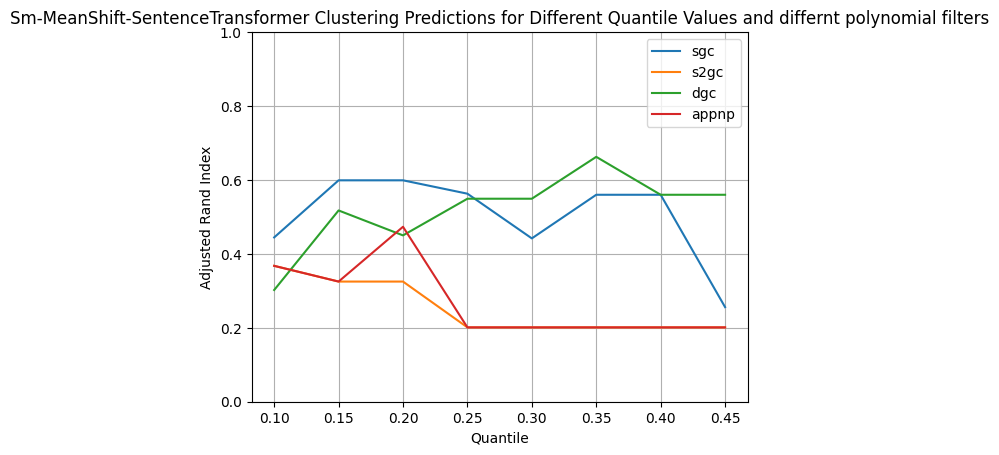

In [64]:
eval_sm_ms= smoothing_meanshift()

In [68]:

eval_s={}
for group, list_of_dicts in eval_sm_ms.items():
    print(f'{group}: list_of_dicts.values()')
    eval_s[f'sm-{group}-ms-st']=list(list_of_dicts.values())
new_eval_s_df = pd.DataFrame(eval_s).transpose()
new_eval_s_df.columns=['Silhouette score', 'Davies-Bouldin Index','Adjusted Mutual Information','Adjusted Rand Index','Bcubed-Precision','Bcubed-Recall','Bcubed-Fscore']
new_eval_s_df2=new_eval_s_df[['Adjusted Mutual Information','Adjusted Rand Index','Bcubed-Precision','Bcubed-Recall','Bcubed-Fscore']]
new_eval_s_df2

sgc: list_of_dicts.values()
s2gc: list_of_dicts.values()
dgc: list_of_dicts.values()
appnp: list_of_dicts.values()


,Adjusted Mutual Information,Adjusted Rand Index,Bcubed-Precision,Bcubed-Recall,Bcubed-Fscore
sm-sgc-ms-st,0.5256,0.5599,0.8328,0.6770,0.7469
sm-s2gc-ms-st,0.3498,0.2011,1.0000,0.5031,0.6694
sm-dgc-ms-st,0.6184,0.6625,0.7809,0.8043,0.7925
sm-appnp-ms-st,0.3498,0.2011,1.0000,0.5031,0.6694


In [70]:
evaluation_metric = pd.concat([new_eval_s_df2,new_eval_s_df1])
evaluation_metric

,Adjusted Mutual Information,Adjusted Rand Index,Bcubed-Precision,Bcubed-Recall,Bcubed-Fscore
sm-sgc-ms-st,0.5256,0.5599,0.8328,0.6770,0.7469
sm-s2gc-ms-st,0.3498,0.2011,1.0000,0.5031,0.6694
sm-dgc-ms-st,0.6184,0.6625,0.7809,0.8043,0.7925
sm-appnp-ms-st,0.3498,0.2011,1.0000,0.5031,0.6694
sm-sgc-hdbscan-st,0.4798,0.3711,0.5502,0.8174,0.6577
sm-s2gc-hdbscan-st,0.5008,0.2781,0.5251,0.8696,0.6548
sm-dgc-hdbscan-st,0.2805,0.1537,0.3411,0.8043,0.4791
sm-appnp-hdbscan-st,0.5008,0.2781,0.5251,0.8696,0.6548


Evaluation K_means

In [132]:
eval_kmeans= kmeans_clustering()

4
Bcubed metric for:
Precision: 0.8782608695652173
Recall: 0.8153846153846154
Fscore: 0.8456556082148498


Precision is a measure of how many of the positive predictions made are correct (true positives).
Recall is a measure of how many of the positive cases the classifier correctly predicted, over all the positive cases in the data.


In [133]:

new_eval_kmeans_df= pd.DataFrame(eval_kmeans, index=['K-means Clustering'])
new_eval_kmeans_df.columns=['Silhouette score', 'Davies-Bouldin Index','Adjusted Mutual Information','Adjusted Rand Index','Bcubed-Precision','Bcubed-Recall','Bcubed-FScore']
new_eval_kmeans_df=new_eval_kmeans_df[['Adjusted Mutual Information','Adjusted Rand Index','Bcubed-Precision','Bcubed-Recall','Bcubed-FScore']]
new_eval_kmeans_df

,Adjusted Mutual Information,Adjusted Rand Index,Bcubed-Precision,Bcubed-Recall,Bcubed-FScore
K-means Clustering,0.726121,0.78322,0.878261,0.815385,0.845656


Evaluation Agglomerative Clustering

In [27]:
eval_agglo=agglomerativeClustering()


Bcubed metric for:
Precision: 0.7333333333333334
Recall: 0.7333333333333334
Fscore: 0.7333333333333335
                                                 text  ActualLabel  \
0   The meeting was about the architecture design ...            0   
1   The meeting was about the Weekly Sync for the ...            0   
2   The meeting was about the performance of the D...            0   
3   This was the second meeting of the new D-goal ...            0   
4   This meeting was about two lists of priorities...            0   
5   This is the second meeting of the team. The me...            1   
6   This meeting was about an investigation into t...            1   
7   This is a webinar on conducting a disciplinary...            1   
8   This meeting was about the future of social me...            2   
9   This is the second meeting of the group. First...            2   
10  The group was moving to a new building across ...            1   
11  This meeting was about the design of the new b...    

In [15]:
import pandas as pd

new_eval_agglo_df= pd.DataFrame(eval_agglo, index=['Agglomerative Clustering'])
new_eval_agglo_df.columns=['Silhouette score', 'Davies-Bouldin Index','Calinski-Harabasz Index','Adjusted Mutual Information','Adjusted Rand Index']
new_eval_agglo_df

,Silhouette score,Davies-Bouldin Index,Calinski-Harabasz Index,Adjusted Mutual Information,Adjusted Rand Index
Agglomerative Clustering,0.113008,1.431205,2.666541,0.457402,0.32107


Evaluation MeanShift

768


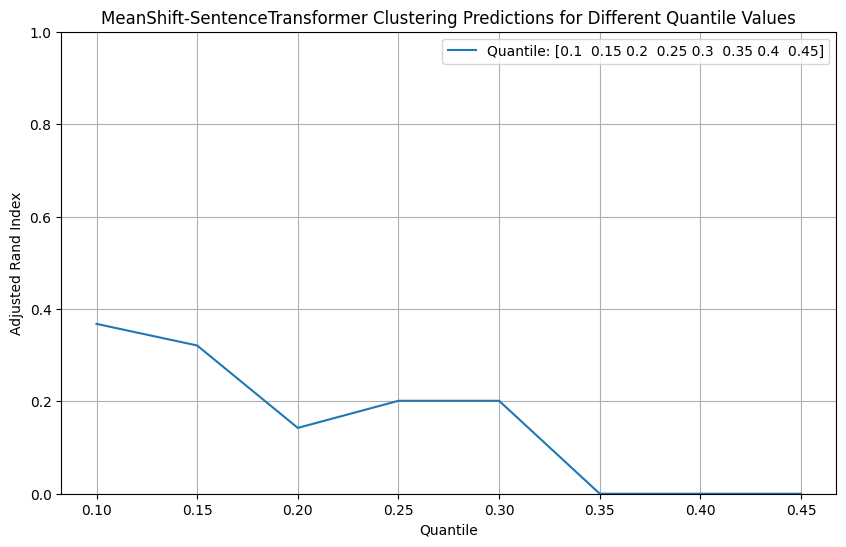

[ 0  1  2  3  4  5  6  7  8  9 10 11]
Bcubed metric for:
Precision: 0.491638795986622
Recall: 0.9227053140096619
Fscore: 0.6414814137860129


In [20]:
eval_ms=meanshiftClustering()

In [21]:
new_eval_ms_df= pd.DataFrame(eval_ms, index=['Mean-Shift Clustering'])
new_eval_ms_df.columns=['Silhouette score', 'Davies-Bouldin Index','Adjusted Mutual Information','Adjusted Rand Index','Bcubed-Precision','Bcubed-Recall','Bcubed-FScore']
new_eval_ms_df=new_eval_ms_df[['Adjusted Mutual Information','Adjusted Rand Index','Bcubed-Precision','Bcubed-Recall','Bcubed-FScore']]
new_eval_ms_df

,Adjusted Mutual Information,Adjusted Rand Index,Bcubed-Precision,Bcubed-Recall,Bcubed-FScore
Mean-Shift Clustering,0.402851,0.367622,0.491639,0.922705,0.641481


Evaluating HDBSCAN

In [22]:
eval_hdscan=hdbscanClustering()
new_eval_h_df= pd.DataFrame(eval_hdscan, index=['HDBSCAN Clustering'])
new_eval_h_df.columns=['Silhouette score', 'Davies-Bouldin Index','Adjusted Mutual Information','Adjusted Rand Index','Bcubed-Precision','Bcubed-Recall','Bcubed-FScore']
new_eval_h_df=new_eval_h_df[['Adjusted Mutual Information','Adjusted Rand Index','Bcubed-Precision','Bcubed-Recall','Bcubed-FScore']]
new_eval_h_df

Best Parameters {'min_cluster_size': 2, 'metric': 'euclidean', 'cluster_selection_method': 'leaf'}
[-1  0  1  2  3  4  5]
Bcubed metric for:
Precision: 0.5033444816053511
Recall: 0.8602484472049691
Fscore: 0.635088815087901


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:988: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 975, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:988: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 975, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^

,Adjusted Mutual Information,Adjusted Rand Index,Bcubed-Precision,Bcubed-Recall,Bcubed-FScore
HDBSCAN Clustering,0.465173,0.289825,0.503344,0.860248,0.635089


In [23]:
evaluation_metric = pd.concat([new_eval_ms_df,new_eval_h_df]) #new_eval_kmeans_df,


In [24]:
evaluation_metric

,Adjusted Mutual Information,Adjusted Rand Index,Bcubed-Precision,Bcubed-Recall,Bcubed-FScore
Mean-Shift Clustering,0.402851,0.367622,0.491639,0.922705,0.641481
HDBSCAN Clustering,0.465173,0.289825,0.503344,0.860248,0.635089
